# World Bank Climate Change Data Preparation

Climate Change Data by WorldBank: https://data.worldbank.org/topic/19

## Table of Contents:
* [Importing Libraries and Dataset](#Importing-Libraries-and-Dataset)
* [Dataset Overview](#Dataset-Overview)
* [Missing Value Identification](#Missing-Value-Identification)
* [Simple EDA](#Simple-EDA)
* [Transposing the Dataset](#Transposing-the-Dataset)
* [Dealing with Missing Values](#Dealing-with-Missing-Values)
	* [Removing Noisy Countries](#Removing-Noisy-Countries)
	* [Dropping Columns with Missing Values > 50%](#Dropping-Columns-with-Missing-Values->-50%)
	* [Dropping previous 20 years](#Dropping-previous-20-years)
    * [Multivariate Imputation](#Multivariate-Imputation)
    * [Analyzing the Imputed Results](#Analyzing-the-Imputed-Results)

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [2]:
# main dataset
df = pd.read_csv('dataset/worldbank/API.csv')

# references and codebooks
meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')
meta_indicator = pd.read_csv('dataset/worldbank/Metadata_Indicator_API_19_DS2_en_csv_v2_3159902.csv')

In [3]:
print(df.shape)
df.head()

(20216, 65)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.940000,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000
1,Aruba,ABW,Urban population,SP.URB.TOTL,27525.000,28139.000000,28537.000000,28763.000000,28922.000000,29080.000000,...,43820.000000,44059.000000,44351.000000,44666.000000,44978.000000,45293.000000,45614.000000,45949.000000,46294.000000,46654.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.206183,1.404498,0.788835,0.551271,0.544810,...,0.100461,0.543931,0.660561,0.707733,0.696090,0.697901,0.706219,0.731740,0.748028,0.774631
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.000,55434.000000,56234.000000,56699.000000,57029.000000,57357.000000,...,102050.000000,102565.000000,103165.000000,103776.000000,104339.000000,104865.000000,105361.000000,105846.000000,106310.000000,106766.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.236462,1.432843,0.823502,0.580334,0.573498,...,0.377979,0.503385,0.583290,0.590508,0.541048,0.502860,0.471874,0.459266,0.437415,0.428017


In [4]:
# function to get indicator name
def indicator_code_to_name(code):
    col = meta_indicator[meta_indicator['INDICATOR_CODE']==code]
    if len(col) == 0:
        return 'the specified column does not exists'
    return str(col.iloc[0]['INDICATOR_NAME'])

# function to get indicator code
def indicator_name_to_code(name):
    col = meta_indicator[meta_indicator['INDICATOR_NAME']==name]
    if len(col) == 0:
        return 'the specified column does not exists'
    return str(col.iloc[0]['INDICATOR_CODE'])
    

In [5]:
# testing the function
indicator_code_to_name('SP.URB.TOTL')

'Urban population'

## Dataset Overview

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216 entries, 0 to 20215
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    20216 non-null  object 
 1   Country Code    20216 non-null  object 
 2   Indicator Name  20216 non-null  object 
 3   Indicator Code  20216 non-null  object 
 4   1960            3133 non-null   float64
 5   1961            4538 non-null   float64
 6   1962            4721 non-null   float64
 7   1963            4581 non-null   float64
 8   1964            4639 non-null   float64
 9   1965            4676 non-null   float64
 10  1966            4688 non-null   float64
 11  1967            4857 non-null   float64
 12  1968            4709 non-null   float64
 13  1969            4716 non-null   float64
 14  1970            5984 non-null   float64
 15  1971            7333 non-null   float64
 16  1972            7541 non-null   float64
 17  1973            7354 non-null  

In [7]:
df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,3.133000e+03,4.538000e+03,4.721000e+03,4.581000e+03,4.639000e+03,4.676000e+03,4.688000e+03,4.857000e+03,4.709000e+03,4.716000e+03,...,1.183800e+04,1.231900e+04,1.081500e+04,1.080100e+04,1.004800e+04,9.138000e+03,8.053000e+03,7.412000e+03,3.661000e+03,2.471000e+03
mean,2.020445e+07,1.479493e+07,1.490789e+07,1.644225e+07,1.690121e+07,1.754138e+07,1.966332e+07,1.972785e+07,2.184618e+07,2.305864e+07,...,6.310504e+08,7.159371e+08,9.751320e+08,1.111048e+09,1.377183e+09,1.352288e+07,1.554424e+07,1.714633e+07,3.484397e+07,5.237699e+07
std,1.768701e+08,1.581155e+08,1.644381e+08,1.828137e+08,1.898935e+08,2.000727e+08,2.377882e+08,2.435295e+08,2.728347e+08,2.929800e+08,...,1.598990e+10,1.834583e+10,2.309879e+10,2.604765e+10,3.091035e+10,1.893776e+08,2.044682e+08,2.159453e+08,3.103152e+08,3.813804e+08
min,-3.667000e+00,-3.667000e+00,-3.667000e+00,-3.703670e+02,-3.667000e+00,-1.450543e+00,-3.667000e+00,-2.011787e+00,-7.260660e+02,-1.892842e+00,...,-7.062298e+05,-4.854332e+05,-4.542582e+05,-6.116137e+05,-6.381096e+05,-7.114856e+05,-2.830723e+01,-1.275190e+03,-1.860016e+01,-1.720565e+00
25%,1.651393e+00,2.717960e+00,2.881118e+00,2.720452e+00,2.649943e+00,2.652144e+00,2.679898e+00,2.842775e+00,2.714277e+00,2.719975e+00,...,1.638896e+00,1.639613e+00,1.800138e+00,1.882970e+00,1.852572e+00,1.985291e+00,2.176847e+00,2.057450e+00,2.857474e+00,2.809923e+00
50%,4.163212e+01,3.036830e+01,3.558600e+01,3.104739e+01,3.135300e+01,3.102728e+01,3.137748e+01,3.653000e+01,3.170570e+01,3.266401e+01,...,2.872923e+01,2.968126e+01,3.082758e+01,3.088500e+01,2.861185e+01,2.718346e+01,2.305038e+01,2.299730e+01,3.216984e+01,3.540044e+01
75%,6.791284e+03,1.771161e+03,1.791461e+03,1.842800e+03,1.847991e+03,1.897191e+03,1.972850e+03,1.952200e+03,2.147145e+03,2.317683e+03,...,7.405562e+02,8.000000e+02,1.820014e+03,1.853100e+03,2.058079e+03,2.318408e+03,1.292000e+03,2.035348e+03,1.000000e+02,4.263420e+04
max,3.040000e+09,3.428000e+09,3.797000e+09,4.362000e+09,4.653000e+09,4.998000e+09,6.127000e+09,6.387000e+09,7.203000e+09,7.830000e+09,...,9.115840e+11,1.067910e+12,1.267130e+12,1.435700e+12,1.644540e+12,7.424485e+09,7.509410e+09,7.592476e+09,7.673345e+09,7.752841e+09


## Missing Value Identification

In [8]:
# function to count missing value
def get_nan(df, sort=False):
    missing_value = df[df.isna().values.any(axis=1)]
    rows = missing_value.shape[0]
    print(rows, "rows with missing values")
    
    if rows < 0:
        return 0
    if sort:
        print(df.isna().sum().sort_values())
    else:
        print(df.isna().sum())
        

In [9]:
get_nan(df, sort=True)

19225 rows with missing values
Country Name          0
Country Code          0
Indicator Name        0
Indicator Code        0
2010               6145
                  ...  
1963              15635
1961              15678
2019              16555
1960              17083
2020              17745
Length: 65, dtype: int64


In [10]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=False):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                     y="variable",
                     hue="missing",
                     multiple="fill",
                     height=10,
                     aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        os.makedirs("plot/") # create a directory
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

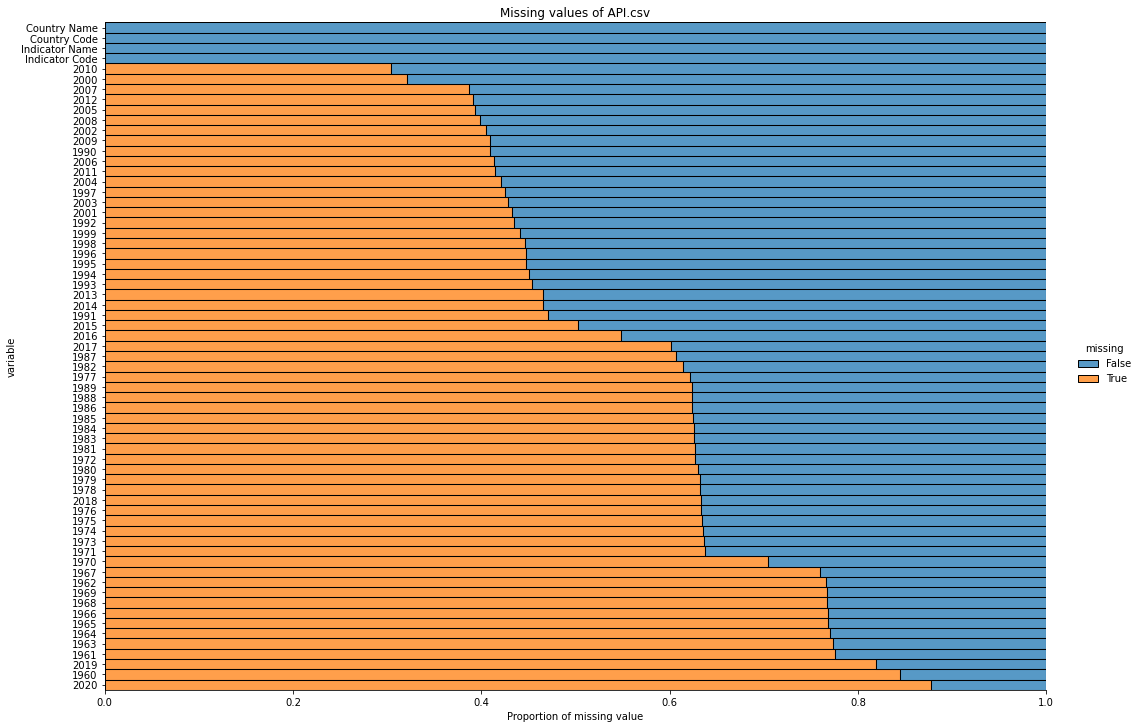

In [11]:
visual_nan(df, 'API.csv', isSorted=True)

In [12]:
missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/25204*100).round(2)

missing.sort_values(by=['ratio'])

,col,missing,ratio
0,Country Name,0,0.00
1,Country Code,0,0.00
2,Indicator Name,0,0.00
3,Indicator Code,0,0.00
54,2010,6145,24.38
...,...,...,...
7,1963,15635,62.03
5,1961,15678,62.20
63,2019,16555,65.68
4,1960,17083,67.78


<AxesSubplot:>

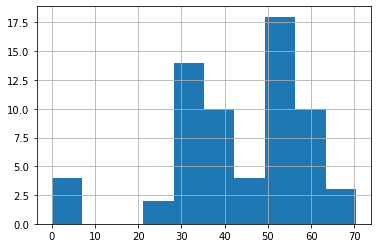

In [13]:
missing.ratio.hist(bins=10)

## Simple EDA

In [14]:
unique_countries = df['Country Name'].unique()
print(unique_countries)
print(len(unique_countries))

['Aruba' 'Africa Eastern and Southern' 'Afghanistan'
 'Africa Western and Central' 'Angola' 'Albania' 'Andorra' 'Arab World'
 'United Arab Emirates' 'Argentina' 'Armenia' 'American Samoa'
 'Antigua and Barbuda' 'Australia' 'Austria' 'Azerbaijan' 'Burundi'
 'Belgium' 'Benin' 'Burkina Faso' 'Bangladesh' 'Bulgaria' 'Bahrain'
 'Bahamas, The' 'Bosnia and Herzegovina' 'Belarus' 'Belize' 'Bermuda'
 'Bolivia' 'Brazil' 'Barbados' 'Brunei Darussalam' 'Bhutan' 'Botswana'
 'Central African Republic' 'Canada' 'Central Europe and the Baltics'
 'Switzerland' 'Channel Islands' 'Chile' 'China' "Cote d'Ivoire"
 'Cameroon' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Colombia' 'Comoros'
 'Cabo Verde' 'Costa Rica' 'Caribbean small states' 'Cuba' 'Curacao'
 'Cayman Islands' 'Cyprus' 'Czech Republic' 'Germany' 'Djibouti'
 'Dominica' 'Denmark' 'Dominican Republic' 'Algeria'
 'East Asia & Pacific (excluding high income)'
 'Early-demographic dividend' 'East Asia & Pacific'
 'Europe & Central Asia (excluding high income)'

In [15]:
unique_country_codes = df['Country Code'].unique()
print(unique_country_codes)
print(len(unique_country_codes))

['ABW' 'AFE' 'AFG' 'AFW' 'AGO' 'ALB' 'AND' 'ARB' 'ARE' 'ARG' 'ARM' 'ASM'
 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN'
 'CEB' 'CHE' 'CHI' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COL' 'COM' 'CPV'
 'CRI' 'CSS' 'CUB' 'CUW' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM'
 'DZA' 'EAP' 'EAR' 'EAS' 'ECA' 'ECS' 'ECU' 'EGY' 'EMU' 'ERI' 'ESP' 'EST'
 'ETH' 'EUU' 'FCS' 'FIN' 'FJI' 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GHA'
 'GIB' 'GIN' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUM' 'GUY' 'HIC'
 'HKG' 'HND' 'HPC' 'HRV' 'HTI' 'HUN' 'IBD' 'IBT' 'IDA' 'IDB' 'IDN' 'IDX'
 'IMN' 'IND' 'INX' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN'
 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT' 'LAC' 'LAO' 'LBN' 'LBR'
 'LBY' 'LCA' 'LCN' 'LDC' 'LIC' 'LIE' 'LKA' 'LMC' 'LMY' 'LSO' 'LTE' 'LTU'
 'LUX' 'LVA' 'MAC' 'MAF' 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEA' 'MEX' 'MHL'
 'MIC' 'MKD' 'MLI' 'MLT' 'MMR' 'MNA' 'MNE' 'MNG' 'M

In [16]:
unique_indicator_names = df['Indicator Name'].unique()
print(unique_indicator_names)
print(len(unique_indicator_names))

['Urban population (% of total population)' 'Urban population'
 'Urban population growth (annual %)' 'Population, total'
 'Population growth (annual %)'
 'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)'
 'Prevalence of underweight, weight for age (% of children under 5)'
 'Community health workers (per 1,000 people)'
 'Mortality rate, under-5 (per 1,000 live births)'
 'Primary completion rate, total (% of relevant age group)'
 'School enrollment, primary and secondary (gross), gender parity index (GPI)'
 'Agriculture, forestry, and fishing, value added (% of GDP)'
 'CPIA public sector management and institutions cluster average (1=low to 6=high)'
 'Ease of doing business rank (1=most business-friendly regulations)'
 'Terrestrial and marine protected areas (% of total territorial area)'
 'Marine protected areas (% of territorial waters)'
 'Terrestrial protected areas (% of total land area)'
 'Annual freshwater withdrawals, total (% of internal resources)'
 'Annual f

In [17]:
unique_indicator_codes = df['Indicator Code'].unique()
print(unique_indicator_codes)
print(len(unique_indicator_codes))

['SP.URB.TOTL.IN.ZS' 'SP.URB.TOTL' 'SP.URB.GROW' 'SP.POP.TOTL'
 'SP.POP.GROW' 'SI.POV.DDAY' 'SH.STA.MALN.ZS' 'SH.MED.CMHW.P3'
 'SH.DYN.MORT' 'SE.PRM.CMPT.ZS' 'SE.ENR.PRSC.FM.ZS' 'NV.AGR.TOTL.ZS'
 'IQ.CPA.PUBS.XQ' 'IC.BUS.EASE.XQ' 'ER.PTD.TOTL.ZS' 'ER.MRN.PTMR.ZS'
 'ER.LND.PTLD.ZS' 'ER.H2O.FWTL.ZS' 'ER.H2O.FWTL.K3' 'EN.URB.MCTY.TL.ZS'
 'EN.POP.EL5M.ZS' 'EN.POP.EL5M.UR.ZS' 'EN.POP.EL5M.RU.ZS' 'EN.CLC.MDAT.ZS'
 'EN.CLC.GHGR.MT.CE' 'EN.CLC.DRSK.XQ' 'EN.ATM.SF6G.KT.CE'
 'EN.ATM.PFCG.KT.CE' 'EN.ATM.NOXE.ZG' 'EN.ATM.NOXE.KT.CE' 'EN.ATM.METH.ZG'
 'EN.ATM.METH.KT.CE' 'EN.ATM.HFCG.KT.CE' 'EN.ATM.GHGT.ZG'
 'EN.ATM.GHGT.KT.CE' 'EN.ATM.GHGO.ZG' 'EN.ATM.GHGO.KT.CE'
 'EN.ATM.CO2E.SF.ZS' 'EN.ATM.CO2E.SF.KT' 'EN.ATM.CO2E.PP.GD.KD'
 'EN.ATM.CO2E.PP.GD' 'EN.ATM.CO2E.PC' 'EN.ATM.CO2E.LF.ZS'
 'EN.ATM.CO2E.LF.KT' 'EN.ATM.CO2E.KT' 'EN.ATM.CO2E.KD.GD'
 'EN.ATM.CO2E.GF.ZS' 'EN.ATM.CO2E.GF.KT' 'EN.ATM.CO2E.EG.ZS'
 'EG.USE.PCAP.KG.OE' 'EG.USE.ELEC.KH.PC' 'EG.USE.COMM.GD.PP.KD'
 'EG.FEC.RNEW.ZS' 'EG.ELC.RNWX.ZS' 

## Transposing the Dataset

The most significant difference that we should take note of is that the `years` and `indicator` (for example, the co2, consumption_co2) are in different x y-axis. The motive of this notebook is to create a function that could help solve this transpose (pivot) issue

In [18]:
# function to slice out country from the worldbank df
# and transpose the data to become year-column format
def get_worlbank_country_year_column(df, country_name, keep_indicator_code=False):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist

    if keep_indicator_code:
        header_to_keep = 'Indicator Code'
        header_to_drop = 'Indicator Name'

    else:
        header_to_keep = 'Indicator Name'
        header_to_drop = 'Indicator Code'
        
    df_country.drop(columns=['Country Name', 'Country Code', f'{header_to_drop}'], inplace=True)
    df_country.reset_index(inplace=True, drop=True)
    df_country.set_index(f'{header_to_keep}')  
    df_country = df_country.transpose()
    df_country.reset_index(inplace=True)
    
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={f'{header_to_keep}': 'Year'}, inplace=True)
    
    # reset column type to float
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [19]:
# create new df for storing transposed data
columns = ['Country Name', 'Year'] + df['Indicator Name'].unique().tolist()
df_transposed = pd.DataFrame([], columns=columns)

# get unique country name
countries = df['Country Name'].unique()

for country in countries:
    df_temp = get_worlbank_country_year_column(df, country, False)
    df_transposed = pd.concat([df_transposed, df_temp], ignore_index=True)
    
df_transposed

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16221,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16222,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16223,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16224,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_transposed.shape

(16226, 78)

In [21]:
df_transposed.to_csv('output/worldbank_transposed.csv', index=False)
print('Completed!')

Completed!


## Dealing with Missing Values

Now that the dataset is transposed, it is time to deal with the missing values that we previously discover.

### Removing Noisy Countries

Why drop these countries?

Check out our [missing value clustering analysis](./missing_value_clustering.ipynb)

In [22]:
countries_to_drop = ['Channel Islands',
    'Curacao',
    'Isle of Man',
    'Kosovo',
    'Monaco',
    'Northern Mariana Islands',
    'Not classified',
    'San Marino',
    'Sint Maarten (Dutch part)',
    'South Sudan',
    'St. Martin (French part)']

df_dropped = df_transposed[~df_transposed['Country Name'].isin(countries_to_drop)]
df_dropped.reset_index(inplace=True, drop=True)
df_dropped 

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15551,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15552,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15553,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping Columns with Missing Values > 50%

Now that the dataset is transposed, we can visualize it properly.

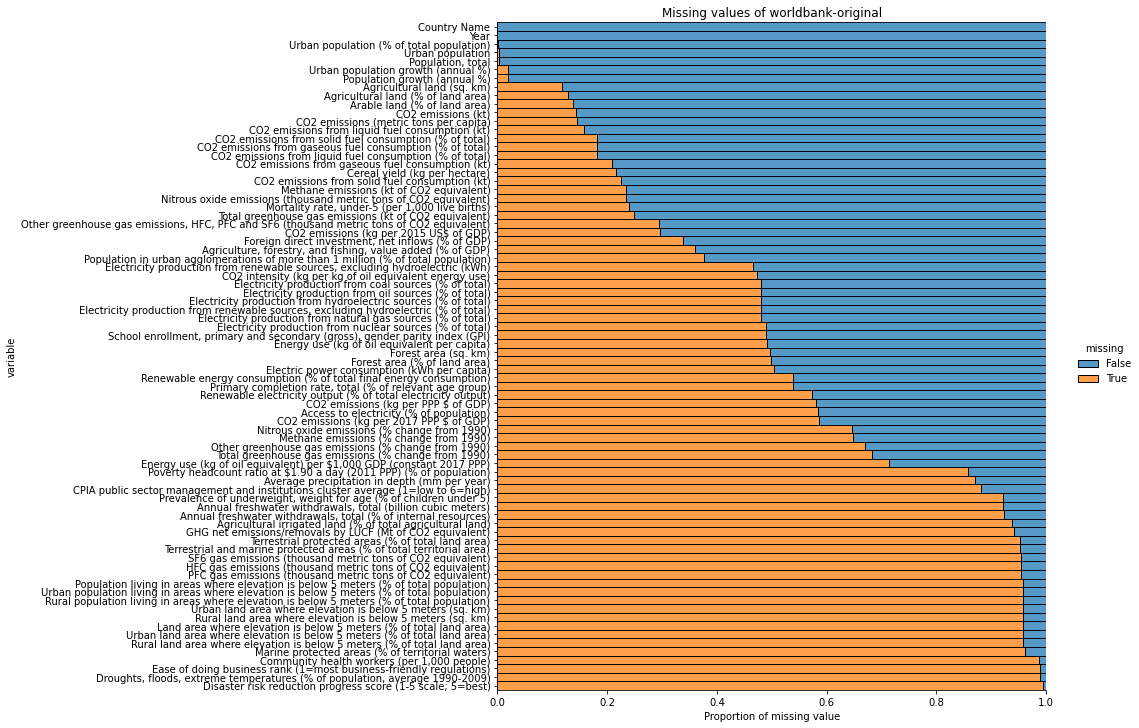

In [23]:
visual_nan(df_dropped, 'worldbank-original', isSorted=True, savePlot=False)

In [24]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    return missing
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
summary = missing_ratio_summary(df_dropped)

,col,missing,ratio
0,Country Name,0,0.00
1,Year,0,0.00
2,Urban population (% of total population),9,0.06
3,Urban population,42,0.27
5,"Population, total",42,0.27
...,...,...,...
17,Marine protected areas (% of territorial waters),14961,96.18
9,"Community health workers (per 1,000 people)",15342,98.63
15,Ease of doing business rank (1=most business-f...,15369,98.80
25,"Droughts, floods, extreme temperatures (% of p...",15387,98.92


In [25]:
missing = pd.DataFrame(df_dropped.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df_dropped)*100).round(2)

print("A list of columns to be dropped (column name, missing value ratio):\n")
for index, row in missing[missing['ratio'] > 50].sort_values(by='ratio').iterrows():
    print("{:<90} {}".format(row.col, row.ratio))

missing_list = missing[missing['ratio'] > 50]['col'].tolist()
print(f"\n{len(missing_list)} columns will be dropped")

A list of columns to be dropped (column name, missing value ratio):

Electric power consumption (kWh per capita)                                                50.34
Renewable energy consumption (% of total final energy consumption)                         53.8
Primary completion rate, total (% of relevant age group)                                   53.9
Renewable electricity output (% of total electricity output)                               57.35
CO2 emissions (kg per PPP $ of GDP)                                                        58.11
Access to electricity (% of population)                                                    58.38
CO2 emissions (kg per 2017 PPP $ of GDP)                                                   58.61
Nitrous oxide emissions (% change from 1990)                                               64.64
Methane emissions (% change from 1990)                                                     64.78
Other greenhouse gas emissions (% change from 1990)         

In [26]:
# Droping the columns
df_dropped = df_dropped.drop(columns=missing_list)

### Dropping previous 20 years

Dropping year 1960-1979 from all countries. Why? Most countries contains missing data in the earliest 20 years

In [27]:
# convert Year column datatype to int
df_dropped["Year"] = df_dropped["Year"].astype(int) 

In [28]:
df_dropped = df_dropped[df_dropped["Year"] >= 1980] # Year is int
df_dropped.reset_index(inplace=True, drop=True)
print(df_dropped.Year.unique())

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [29]:
df_dropped

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,50.472,30332.0,0.178188,60097.0,0.208214,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
1,Aruba,1981,50.456,30557.0,0.739053,60561.0,0.769120,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1982,50.441,30941.0,1.248837,61341.0,1.279734,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1983,50.426,31372.0,1.383361,62213.0,1.411552,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1984,50.411,31671.0,0.948566,62826.0,0.980502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.5,NaN,7.873986,...,NaN,NaN,NaN,1.669274,435.1,45.570273,176288.6,10.339925,41.876696,162000.0
10451,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.2,NaN,7.713516,...,NaN,NaN,NaN,1.299939,622.0,45.451183,175827.9,10.339925,41.876696,162000.0
10452,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.9,NaN,5.074000,...,NaN,NaN,NaN,3.814032,579.1,45.332093,175367.2,10.339925,41.876696,162000.0
10453,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.6,NaN,NaN,...,NaN,NaN,NaN,1.653631,NaN,45.213002,174906.5,NaN,NaN,NaN


### Multivariate Imputation

Impute the missing values

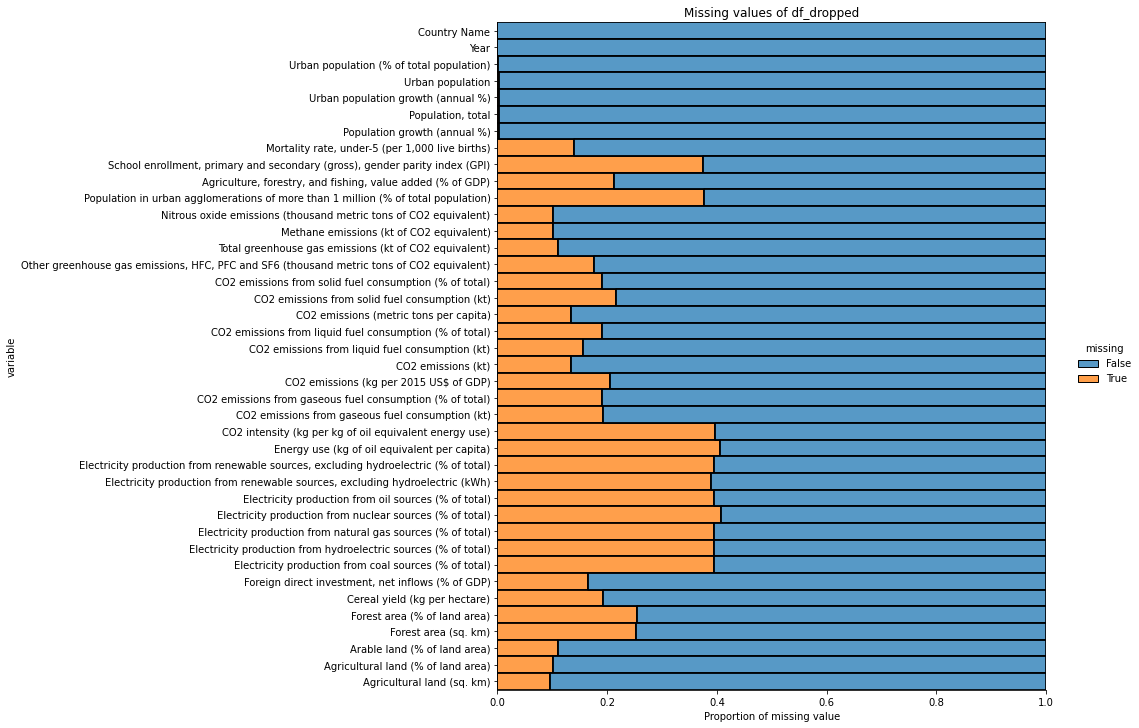

In [114]:
visual_nan(df_dropped, name="df_dropped", isSorted=False, savePlot=False)

<AxesSubplot:>

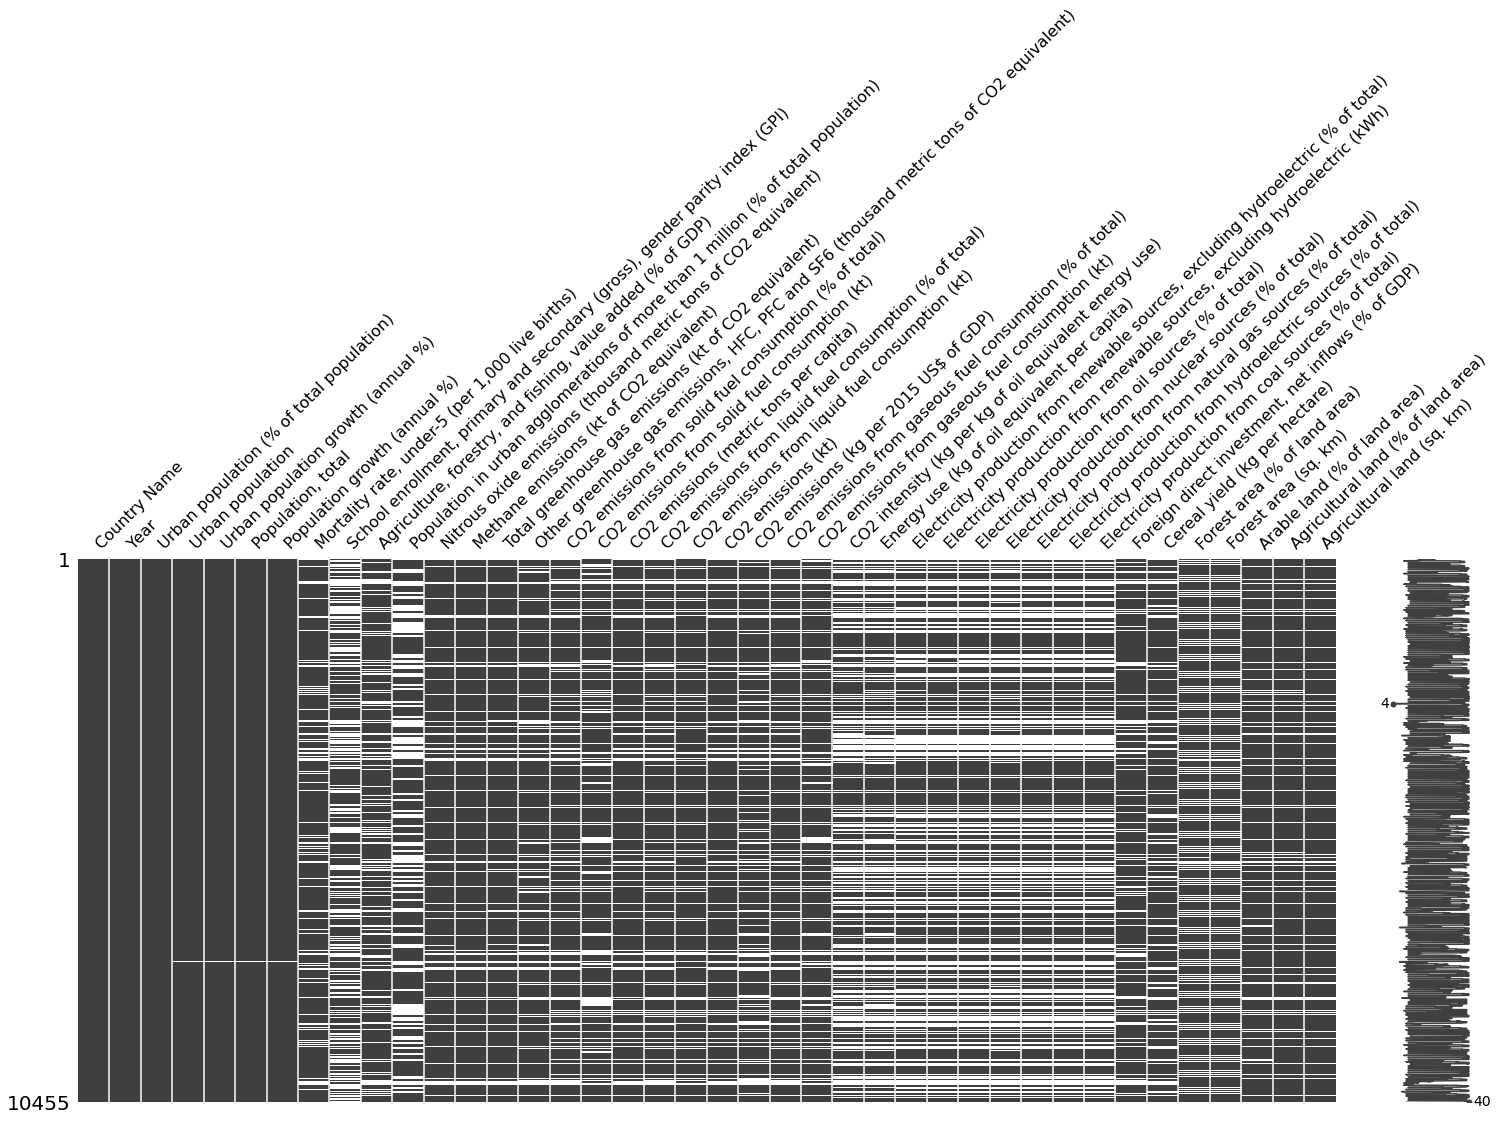

In [31]:
msno.matrix(df_dropped)

In [32]:
print(df_dropped.isnull().sum())
len(df_dropped)

Country Name                                                                                    0
Year                                                                                            0
Urban population (% of total population)                                                        9
Urban population                                                                               22
Urban population growth (annual %)                                                             24
Population, total                                                                              22
Population growth (annual %)                                                                   25
Mortality rate, under-5 (per 1,000 live births)                                              1452
School enrollment, primary and secondary (gross), gender parity index (GPI)                  3909
Agriculture, forestry, and fishing, value added (% of GDP)                                   2218
Population in urban 

10455

In [33]:
df_dropped

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,50.472,30332.0,0.178188,60097.0,0.208214,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
1,Aruba,1981,50.456,30557.0,0.739053,60561.0,0.769120,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1982,50.441,30941.0,1.248837,61341.0,1.279734,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1983,50.426,31372.0,1.383361,62213.0,1.411552,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1984,50.411,31671.0,0.948566,62826.0,0.980502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.5,NaN,7.873986,...,NaN,NaN,NaN,1.669274,435.1,45.570273,176288.6,10.339925,41.876696,162000.0
10451,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.2,NaN,7.713516,...,NaN,NaN,NaN,1.299939,622.0,45.451183,175827.9,10.339925,41.876696,162000.0
10452,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.9,NaN,5.074000,...,NaN,NaN,NaN,3.814032,579.1,45.332093,175367.2,10.339925,41.876696,162000.0
10453,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.6,NaN,NaN,...,NaN,NaN,NaN,1.653631,NaN,45.213002,174906.5,NaN,NaN,NaN


In [38]:
country_names = df_dropped.iloc[:, :1] # country column only
df_to_impute = df_dropped.iloc[:, 1:] # df exclude country column
df_to_impute

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,1980,50.472,30332.0,0.178188,60097.0,0.208214,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
1,1981,50.456,30557.0,0.739053,60561.0,0.769120,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,1982,50.441,30941.0,1.248837,61341.0,1.279734,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,1983,50.426,31372.0,1.383361,62213.0,1.411552,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,1984,50.411,31671.0,0.948566,62826.0,0.980502,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.5,NaN,7.873986,10.725351,...,NaN,NaN,NaN,1.669274,435.1,45.570273,176288.6,10.339925,41.876696,162000.0
10451,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.2,NaN,7.713516,10.605770,...,NaN,NaN,NaN,1.299939,622.0,45.451183,175827.9,10.339925,41.876696,162000.0
10452,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.9,NaN,5.074000,10.492664,...,NaN,NaN,NaN,3.814032,579.1,45.332093,175367.2,10.339925,41.876696,162000.0
10453,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.6,NaN,NaN,10.387585,...,NaN,NaN,NaN,1.653631,NaN,45.213002,174906.5,NaN,NaN,NaN


In [42]:
imputer = IterativeImputer(max_iter=50, initial_strategy='median', random_state=2022)
imputer.fit(df_to_impute)

IterativeImputer(initial_strategy='median', max_iter=50, random_state=2022)

In [45]:
array_imputed = imputer.transform(df_to_impute)

In [46]:
array_imputed.shape

(10455, 39)

In [50]:
df_imputed = pd.DataFrame(array_imputed, columns=df_to_impute.columns.tolist())
df_imputed['Year'] = df_imputed['Year'].astype('int')
df_imputed['Country Name'] = country_names['Country Name']

# rearrange the columns
cols = df_imputed.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_imputed = df_imputed[cols]
df_imputed

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,50.472,30332.0,0.178188,60097.0,0.208214,-221.349784,1.827218,-58.576076,...,61.642394,-189.914901,43.750010,632.512230,22596.465871,-46.974576,132056.562767,11.111111,11.111111,20.000000
1,Aruba,1981,50.456,30557.0,0.739053,60561.0,0.769120,-200.916137,1.765095,-53.753051,...,59.302384,-177.137934,41.237923,595.470717,21425.180786,-43.302222,123040.462682,11.111111,11.111111,20.000000
2,Aruba,1982,50.441,30941.0,1.248837,61341.0,1.279734,-224.075437,1.845928,-60.474286,...,67.538307,-202.611275,46.688480,655.647106,23418.109822,-55.119390,137153.231848,11.111111,11.111111,20.000000
3,Aruba,1983,50.426,31372.0,1.383361,62213.0,1.411552,-78.921730,1.368124,-21.745296,...,32.069325,-74.012430,19.888605,329.159927,12806.934300,-2.941954,58005.865109,11.111111,11.111111,20.000000
4,Aruba,1984,50.411,31671.0,0.948566,62826.0,0.980502,-303.808472,2.102306,-80.807061,...,85.700069,-268.610244,60.326504,825.299596,28965.691209,-81.260515,175694.110344,11.111111,11.111111,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.500000,0.969053,7.873986,...,-2.090435,33.002775,55.551563,1.669274,435.100000,45.570273,176288.600000,10.339925,41.876696,162000.000000
10451,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.200000,0.981076,7.713516,...,15.680365,35.986903,16.988386,1.299939,622.000000,45.451183,175827.900000,10.339925,41.876696,162000.000000
10452,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.900000,0.991446,5.074000,...,17.827762,30.145855,19.496705,3.814032,579.100000,45.332093,175367.200000,10.339925,41.876696,162000.000000
10453,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.600000,0.957838,19.612315,...,17.281288,52.115226,5.361520,1.653631,2660.080575,45.213002,174906.500000,13.405833,35.190874,250039.468022


### Analyzing the Imputed Results

Let's compare the statistics before and after the imputation

In [80]:
df_imputed.describe()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
count,10455.000000,10455.000000,1.045500e+04,10455.000000,1.045500e+04,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,...,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,1.045500e+04,10455.000000,10455.000000,1.045500e+04
mean,2000.000000,53.523070,1.158406e+08,2.490814,2.540027e+08,1.603055,57.505747,0.935963,13.671619,22.055815,...,17.853128,34.587404,14.066967,6.755622,2803.109344,33.560373,1.508057e+06,13.298349,37.323593,1.832515e+06
std,11.832725,23.430263,3.670434e+08,2.083582,7.974253e+08,1.406337,59.943059,0.120779,12.241974,25.555469,...,23.309405,30.509109,23.632564,45.488275,2100.938754,22.129279,4.718416e+06,12.202556,19.483277,5.238815e+06
min,1980.000000,4.339000,-8.513760e+06,-7.183060,-5.589066e+06,-6.766133,-373.486475,0.000000,-98.134670,-827.240750,...,-53.846708,-534.784847,-147.435710,-1275.189986,-3762.058170,-101.407981,-1.457244e+07,-4.876180,0.442308,-5.611215e+05
25%,1990.000000,33.786500,7.201835e+05,0.984729,1.731186e+06,0.616634,13.900000,0.885529,3.917707,11.316472,...,0.173452,11.786835,0.000000,0.548679,1448.800000,16.587070,2.777075e+03,4.406580,23.499333,1.072000e+04
50%,2000.000000,52.836000,4.035650e+06,2.346393,8.840998e+06,1.531566,35.176151,0.978410,10.501291,18.411185,...,9.909138,29.607940,3.275650,2.084109,2479.700000,33.029115,4.354252e+04,10.281911,37.593583,8.453000e+04
75%,2010.000000,72.615888,3.197108e+07,3.795360,5.705346e+07,2.541299,86.716627,1.009698,21.333672,29.707896,...,26.664595,54.564122,22.230627,5.249117,3653.813836,47.415428,3.530502e+05,17.578125,49.340458,4.719800e+05
max,2020.000000,100.000000,4.352232e+09,48.935569,7.752841e+09,17.512207,356.429420,2.322708,79.042362,595.680212,...,163.158229,165.916794,166.964607,1704.590134,36761.900000,104.182850,5.171331e+07,73.388646,86.167295,4.808821e+07


Looking at the minimum values of each column (min), there seems to have a handful of columns with less than 0 as minimum value.  
To answer if this is normal, let's have a look at the original summary of the DataFrame before imputation.

In [88]:
summary_original = df_dropped.describe().transpose()

print("Columns with minimum value less than zero BEFORE imputation: \n")
print(summary_original[summary_original['min']<0]['min'])

Columns with minimum value less than zero BEFORE imputation: 

Urban population growth (annual %)                                                          -7.183060e+00
Population growth (annual %)                                                                -6.766133e+00
Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)   -1.064283e+06
CO2 emissions from solid fuel consumption (% of total)                                      -4.323570e+00
CO2 emissions from solid fuel consumption (kt)                                              -1.136770e+02
CO2 emissions from liquid fuel consumption (% of total)                                     -4.014963e+01
CO2 emissions from liquid fuel consumption (kt)                                             -5.903870e+02
Foreign direct investment, net inflows (% of GDP)                                           -1.275190e+03
Name: min, dtype: float64


In [87]:
summary_imputed = df_imputed.describe().transpose()

print("Columns with minimum value less than zero AFTER imputation: \n")
print(summary_imputed[summary_imputed['min']<0]['min'])

Columns with minimum value less than zero AFTER imputation: 

Urban population                                                                            -8.513760e+06
Urban population growth (annual %)                                                          -7.183060e+00
Population, total                                                                           -5.589066e+06
Population growth (annual %)                                                                -6.766133e+00
Mortality rate, under-5 (per 1,000 live births)                                             -3.734865e+02
Agriculture, forestry, and fishing, value added (% of GDP)                                  -9.813467e+01
Population in urban agglomerations of more than 1 million (% of total population)           -8.272407e+02
Nitrous oxide emissions (thousand metric tons of CO2 equivalent)                            -4.511513e+02
Methane emissions (kt of CO2 equivalent)                                                  

There seems to have a few columns that shouldn't have minimum values with less than zero.  
We will fix them by replacing values less than 0 with 0.

In [101]:
acceptable_cols = summary_original[summary_original['min']<0]['min'].index.tolist()
imputed_cols = summary_imputed[summary_imputed['min']<0]['min'].index.tolist()

cols_to_fix = [col for col in imputed_cols if col not in acceptable_cols]

In [104]:
df_imputed_2 = df_imputed.copy()

# display the number of values less than 0 in each target column
values_to_be_correct = []
for col in cols_to_fix:
    incorrect_count = df_imputed[f"{col}"][df_imputed[f"{col}"]<0].count()
    values_to_be_correct.append([col, incorrect_count])
    
df_to_be_correct = pd.DataFrame(values_to_be_correct, columns=["column", "number of values less than zero"])
display(df_to_be_correct)

# replace values in above mentioned columns that are less than 0 with 0
for col in cols_to_fix:
    df_imputed_2[f"{col}"] = np.where(df_imputed_2[f"{col}"] < 0, 0.0, df_imputed_2[f"{col}"])
    
df_imputed_2

,column,number of values less than zero
0,Urban population,13
1,"Population, total",12
2,"Mortality rate, under-5 (per 1,000 live births)",310
3,"Agriculture, forestry, and fishing, value adde...",333
4,Population in urban agglomerations of more tha...,417
5,Nitrous oxide emissions (thousand metric tons ...,2
6,Methane emissions (kt of CO2 equivalent),269
7,Total greenhouse gas emissions (kt of CO2 equi...,69
8,CO2 emissions (metric tons per capita),111
9,CO2 emissions (kt),96


,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,50.472,30332.0,0.178188,60097.0,0.208214,0.000000,1.827218,0.000000,...,61.642394,0.000000,43.750010,632.512230,22596.465871,0.000000,132056.562767,11.111111,11.111111,20.000000
1,Aruba,1981,50.456,30557.0,0.739053,60561.0,0.769120,0.000000,1.765095,0.000000,...,59.302384,0.000000,41.237923,595.470717,21425.180786,0.000000,123040.462682,11.111111,11.111111,20.000000
2,Aruba,1982,50.441,30941.0,1.248837,61341.0,1.279734,0.000000,1.845928,0.000000,...,67.538307,0.000000,46.688480,655.647106,23418.109822,0.000000,137153.231848,11.111111,11.111111,20.000000
3,Aruba,1983,50.426,31372.0,1.383361,62213.0,1.411552,0.000000,1.368124,0.000000,...,32.069325,0.000000,19.888605,329.159927,12806.934300,0.000000,58005.865109,11.111111,11.111111,20.000000
4,Aruba,1984,50.411,31671.0,0.948566,62826.0,0.980502,0.000000,2.102306,0.000000,...,85.700069,0.000000,60.326504,825.299596,28965.691209,0.000000,175694.110344,11.111111,11.111111,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.500000,0.969053,7.873986,...,0.000000,33.002775,55.551563,1.669274,435.100000,45.570273,176288.600000,10.339925,41.876696,162000.000000
10451,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.200000,0.981076,7.713516,...,15.680365,35.986903,16.988386,1.299939,622.000000,45.451183,175827.900000,10.339925,41.876696,162000.000000
10452,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.900000,0.991446,5.074000,...,17.827762,30.145855,19.496705,3.814032,579.100000,45.332093,175367.200000,10.339925,41.876696,162000.000000
10453,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.600000,0.957838,19.612315,...,17.281288,52.115226,5.361520,1.653631,2660.080575,45.213002,174906.500000,13.405833,35.190874,250039.468022


In [110]:
df_imputed_2.describe()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
count,10455.000000,10455.000000,1.045500e+04,10455.000000,1.045500e+04,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,...,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,1.045500e+04,10455.000000,10455.000000,1.045500e+04
mean,2000.000000,53.523070,1.158430e+08,2.490814,2.540080e+08,1.603055,58.103181,0.935963,13.803128,22.673550,...,18.214461,34.922141,15.215852,6.755622,2807.073032,33.642650,1.552058e+06,13.300408,37.323593,1.832869e+06
std,11.832725,23.430263,3.670426e+08,2.083582,7.974236e+08,1.406337,58.931346,0.120779,11.965029,20.656504,...,22.946824,28.389941,22.414731,45.488275,2093.034809,21.939605,4.658629e+06,12.200051,19.483277,5.238683e+06
min,1980.000000,4.339000,0.000000e+00,-7.183060,0.000000e+00,-6.766133,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1275.189986,0.000000,0.000000,0.000000e+00,0.000000,0.442308,0.000000e+00
25%,1990.000000,33.786500,7.201835e+05,0.984729,1.731186e+06,0.616634,13.900000,0.885529,3.917707,11.316472,...,0.173452,11.786835,0.000000,0.548679,1448.800000,16.587070,2.777075e+03,4.406580,23.499333,1.072000e+04
50%,2000.000000,52.836000,4.035650e+06,2.346393,8.840998e+06,1.531566,35.176151,0.978410,10.501291,18.411185,...,9.909138,29.607940,3.275650,2.084109,2479.700000,33.029115,4.354252e+04,10.281911,37.593583,8.453000e+04
75%,2010.000000,72.615888,3.197108e+07,3.795360,5.705346e+07,2.541299,86.716627,1.009698,21.333672,29.707896,...,26.664595,54.564122,22.230627,5.249117,3653.813836,47.415428,3.530502e+05,17.578125,49.340458,4.719800e+05
max,2020.000000,100.000000,4.352232e+09,48.935569,7.752841e+09,17.512207,356.429420,2.322708,79.042362,595.680212,...,163.158229,165.916794,166.964607,1704.590134,36761.900000,104.182850,5.171331e+07,73.388646,86.167295,4.808821e+07


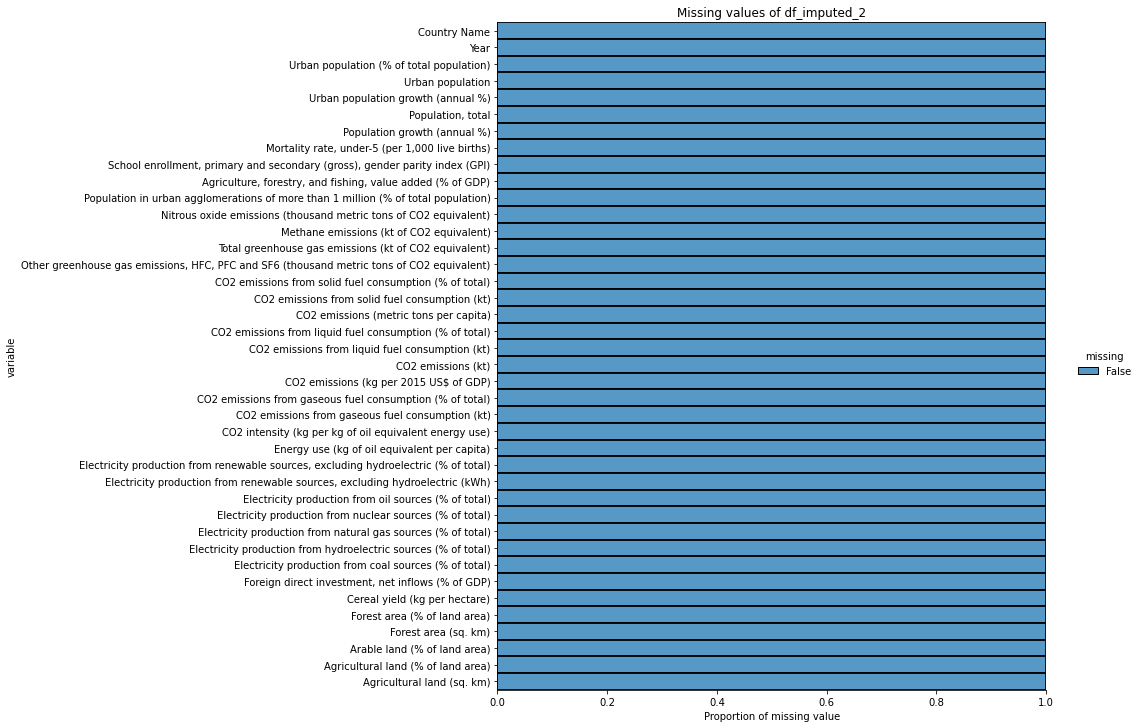

In [113]:
visual_nan(df_imputed_2, name="df_imputed_2", isSorted=False, savePlot=False)

In [116]:
df_to_impute.columns.tolist()

['Year',
 'Urban population (% of total population)',
 'Urban population',
 'Urban population growth (annual %)',
 'Population, total',
 'Population growth (annual %)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'School enrollment, primary and secondary (gross), gender parity index (GPI)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
 'Methane emissions (kt of CO2 equivalent)',
 'Total greenhouse gas emissions (kt of CO2 equivalent)',
 'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)',
 'CO2 emissions from solid fuel consumption (% of total)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (metric tons per capita)',
 'CO2 emissions from liquid fuel consumption (% of total)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt

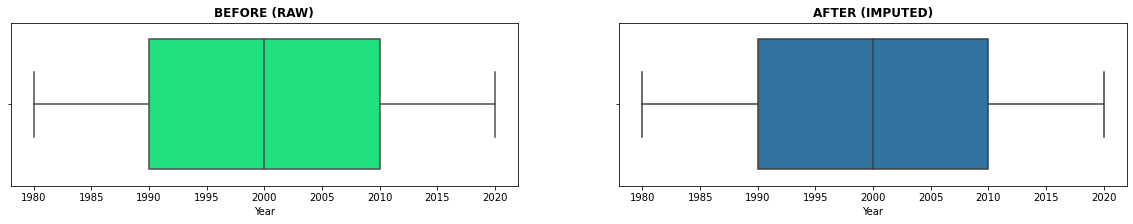

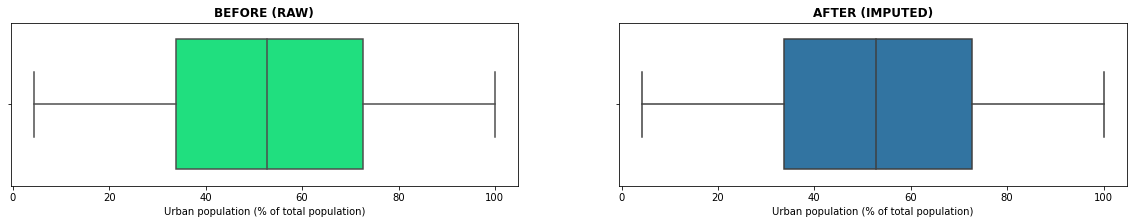

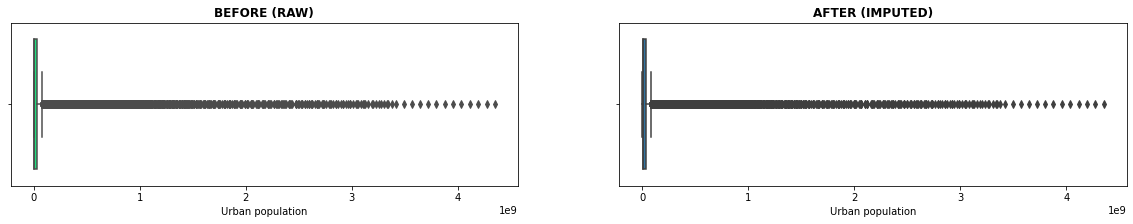

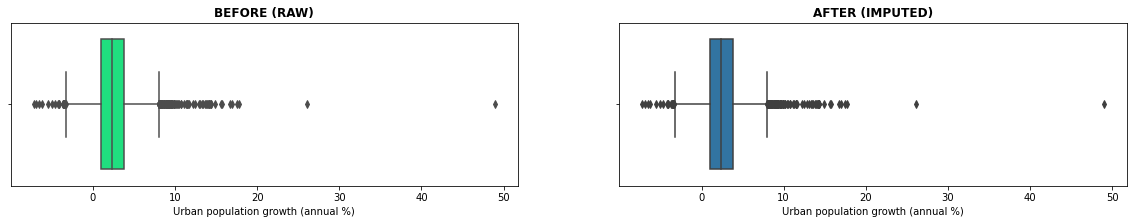

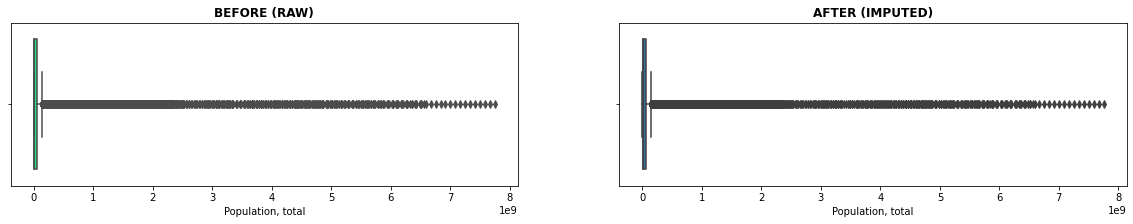

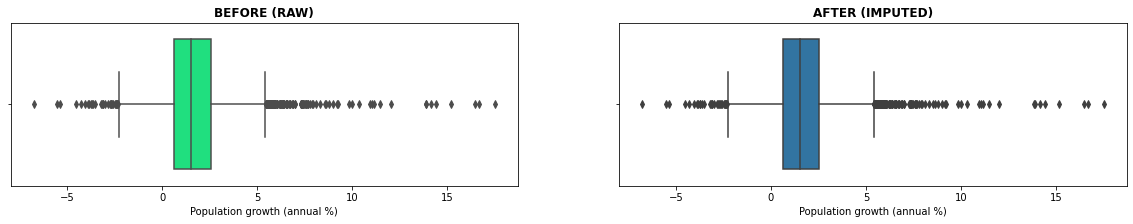

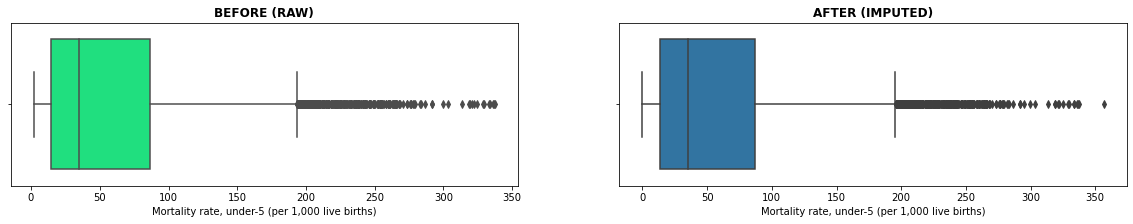

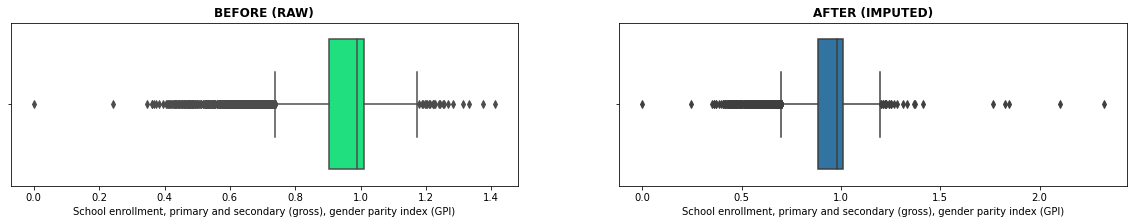

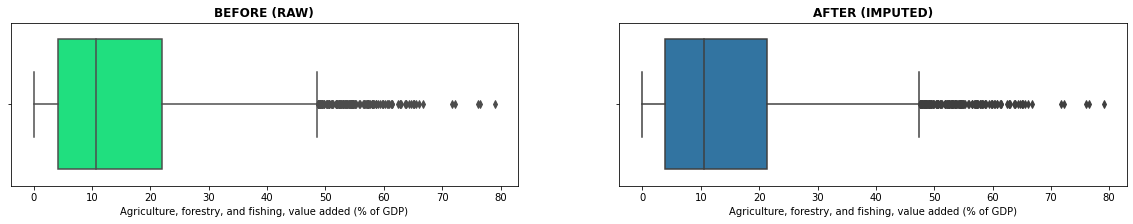

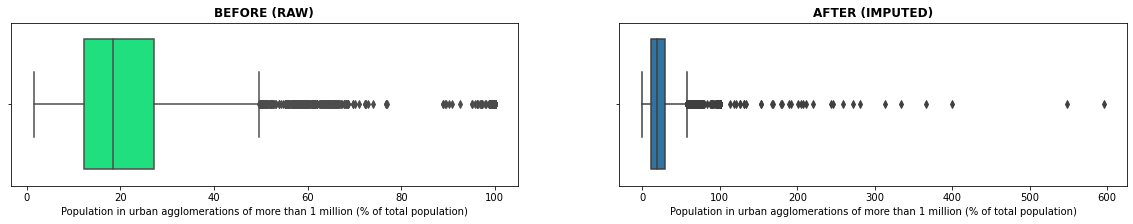

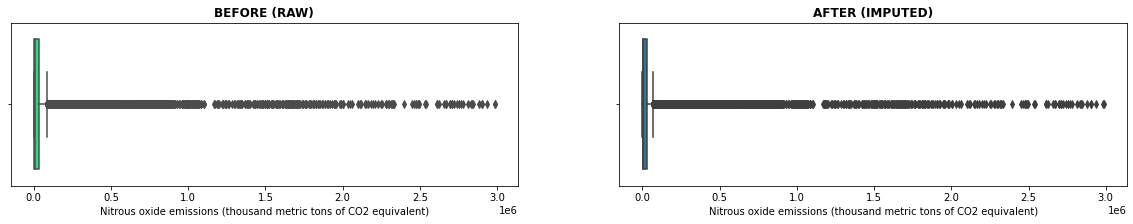

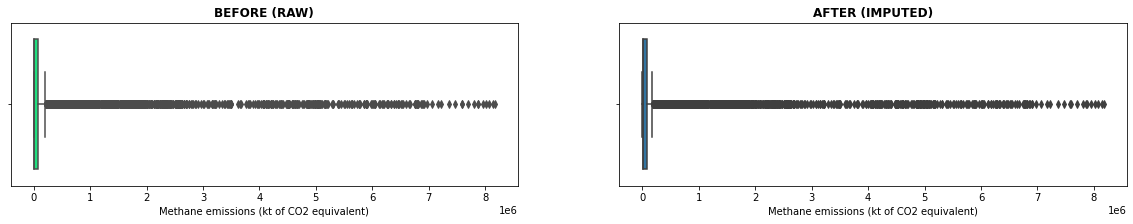

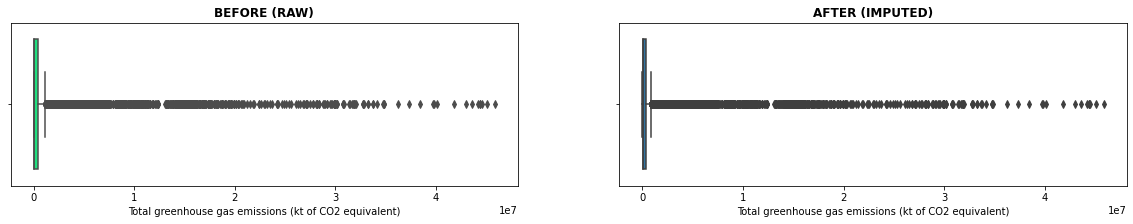

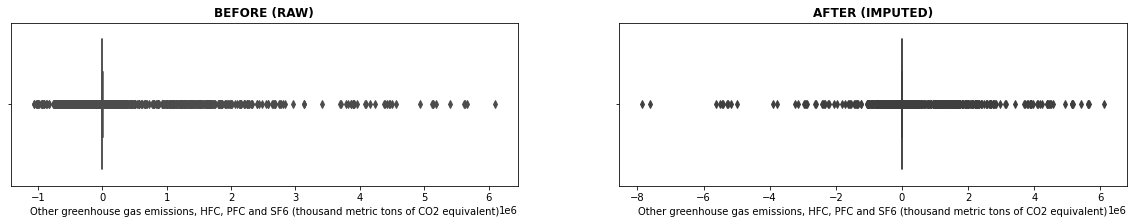

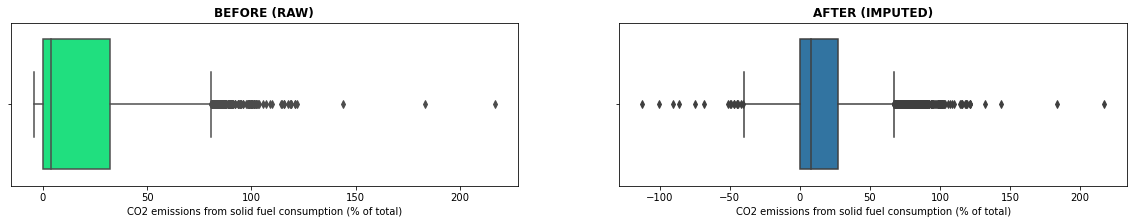

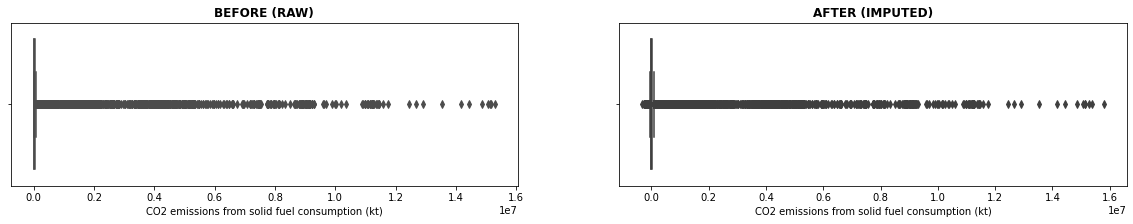

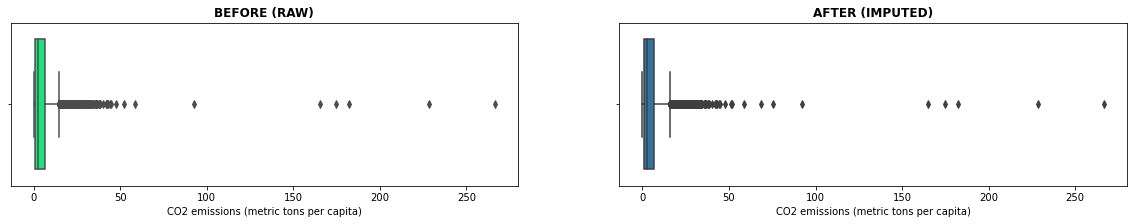

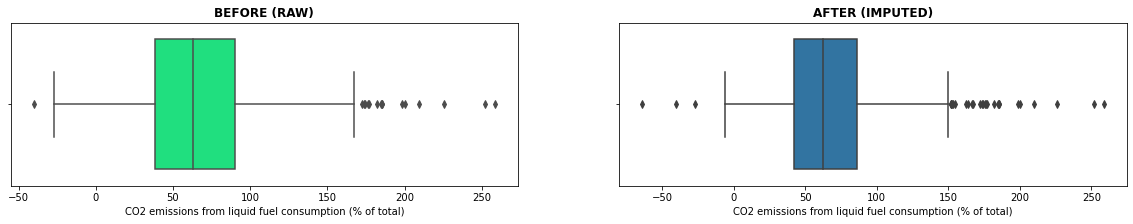

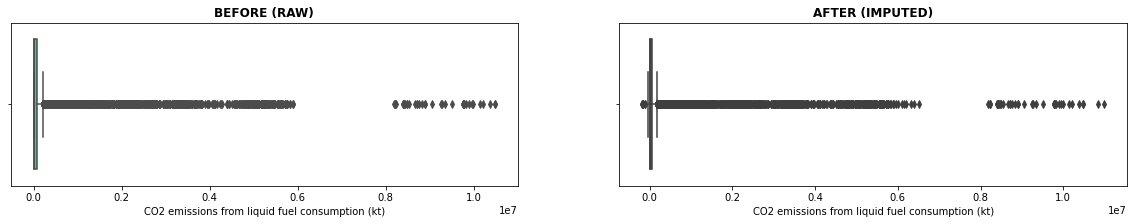

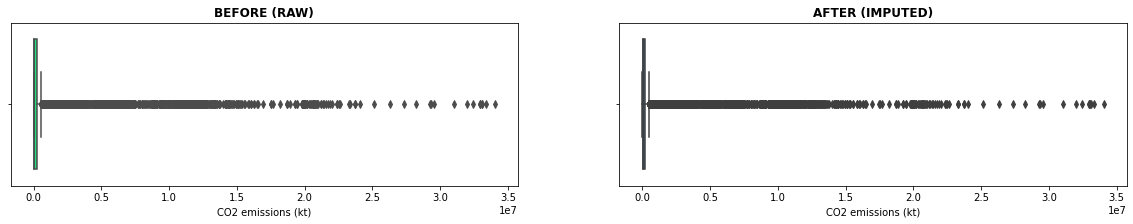

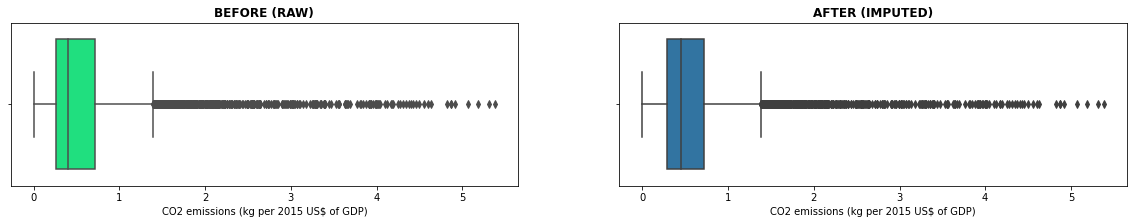

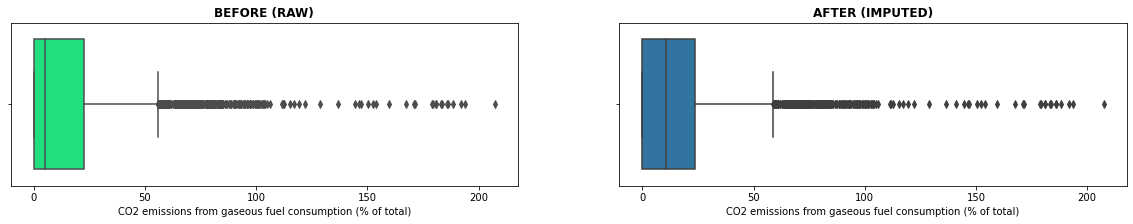

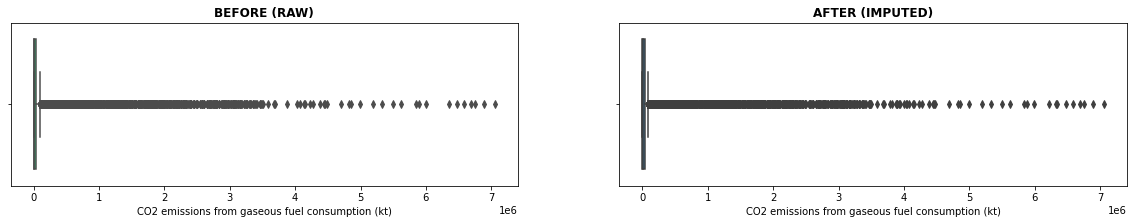

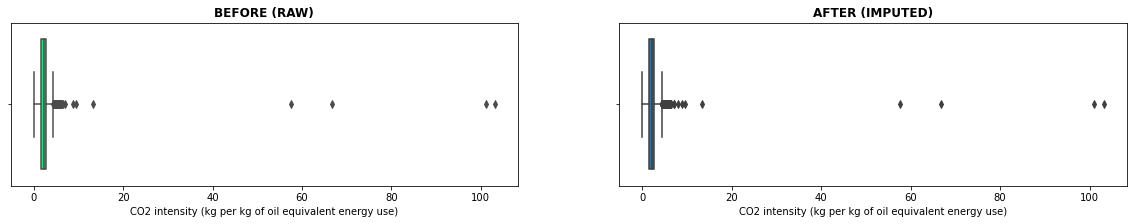

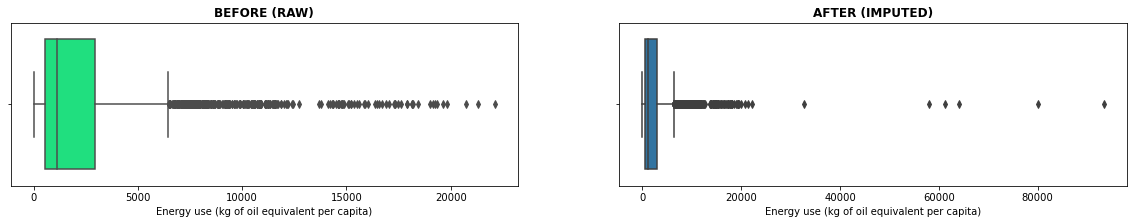

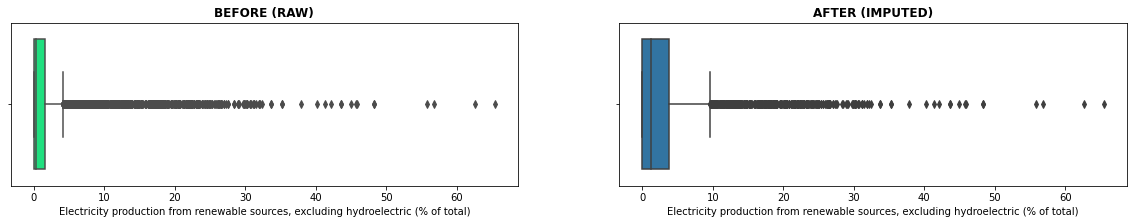

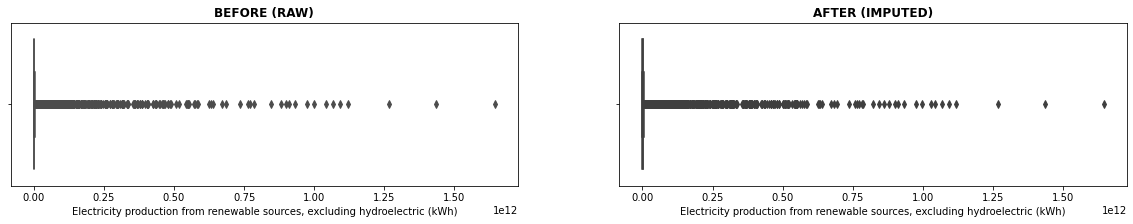

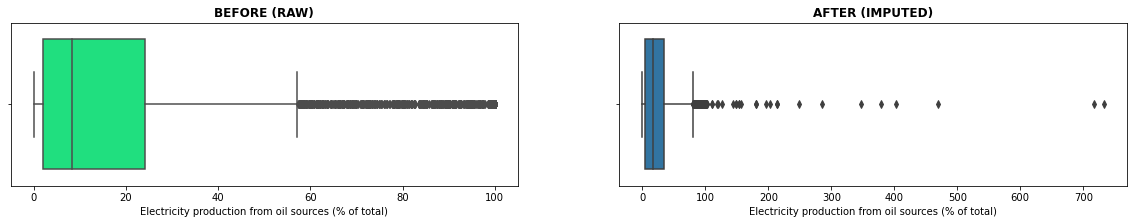

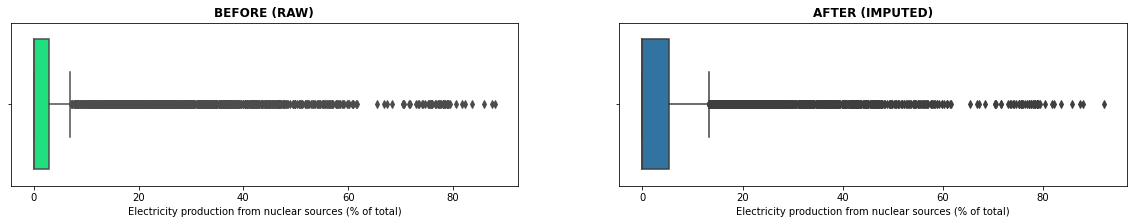

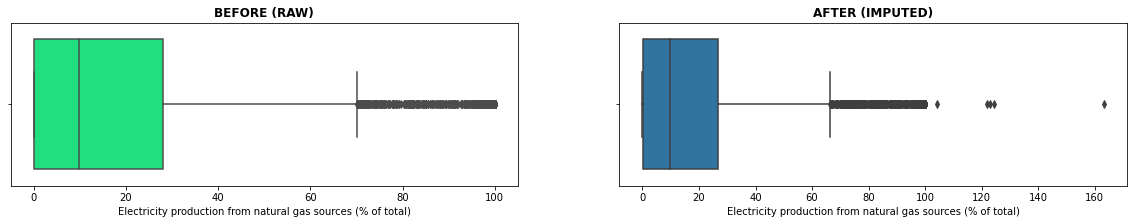

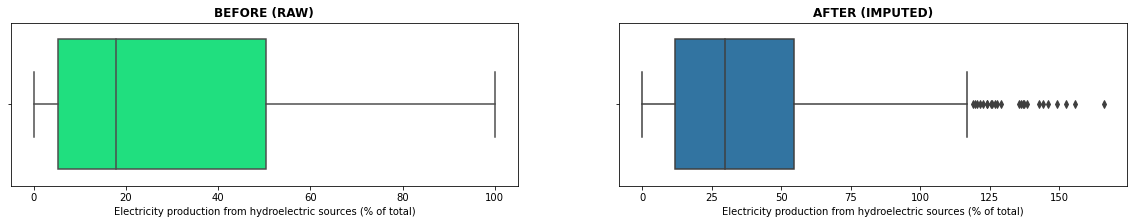

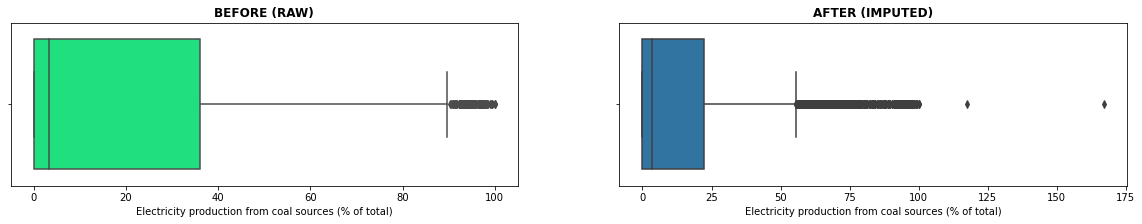

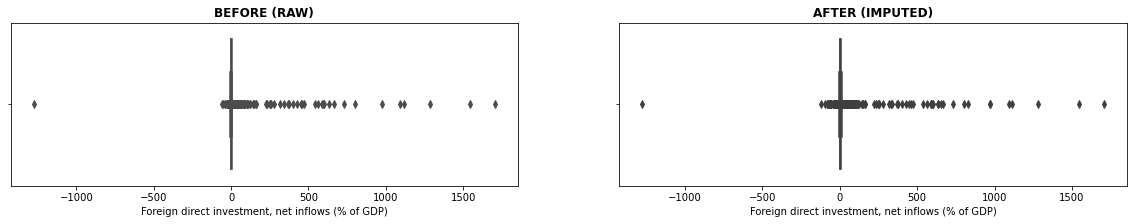

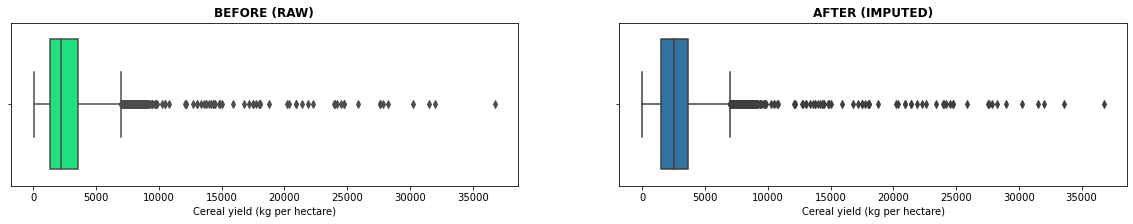

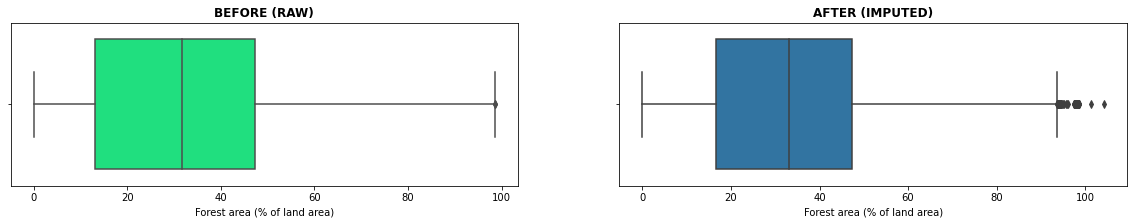

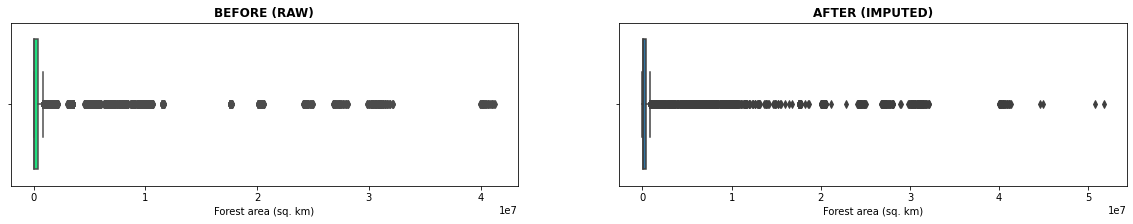

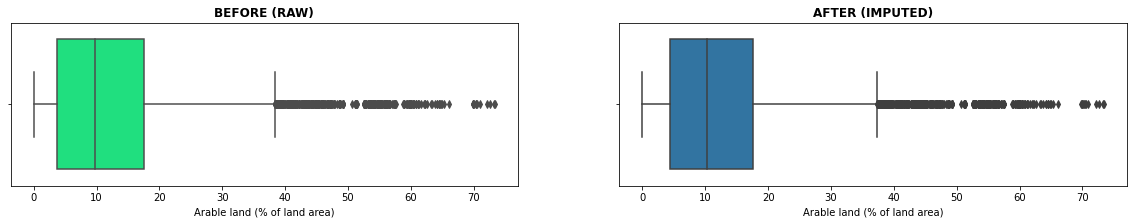

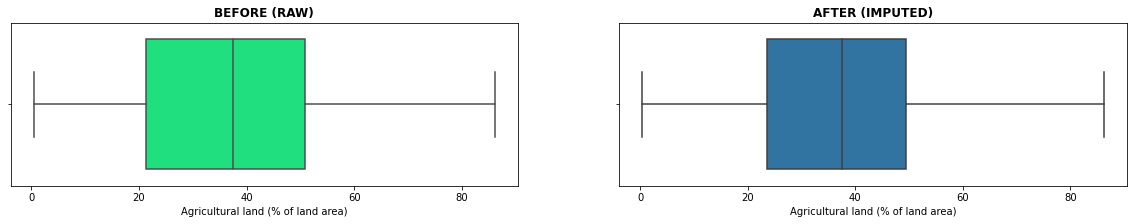

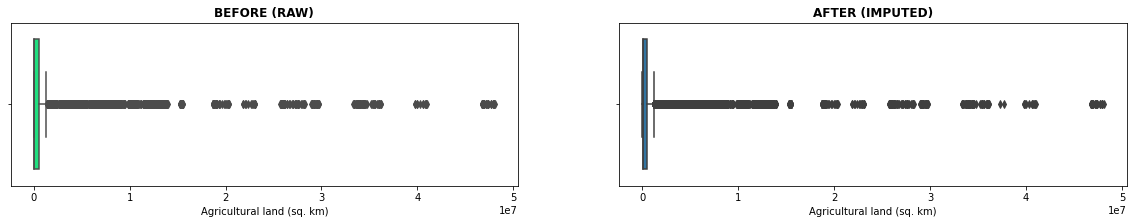

In [117]:
# comparing data before and after imputed
for col in df_to_impute.columns.tolist():
    plt.figure(figsize=(20, 3))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_dropped[f"{col}"], color="springgreen")
    plt.title("BEFORE (RAW)", fontweight="bold")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_imputed_2[f"{col}"])
    plt.title("AFTER (IMPUTED)", fontweight="bold")
    
    plt.show()

In [118]:
df_imputed_2.to_csv('output/worldbank_imputed.csv', index=False)
print('Completed!')

Completed!
